In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from torch import nn
import torch.nn.functional as F
from scipy.stats import linregress
from pathlib import Path

In [64]:
class IMUDataset(Dataset):
    def __init__(self, df, winsize=250, stride=50, transform=None):
        self.X = torch.from_numpy(df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values)
        if transform is not None:
            self.X = transform(self.X)
        self.X = self.X.transpose(0, 1).to(torch.float32)
        self.winsize = winsize
        self.stride = stride
        self.len = (self.X.shape[1] - winsize) // stride + 1
    def __len__(self):
        return self.len
    def __getitem__(self, i):
        start = i * self.stride
        end = start + self.winsize
        return self.X[:,start:end]


In [65]:
df = pd.read_csv('data/data.csv')
session_ids = df['session_id'].unique()
print(len(session_ids))
train_ids, val_ids = train_test_split(session_ids, test_size=0.2, random_state=42)

47


In [79]:
HZ = 100
dfs = []
for file in Path('data/elshafei_data_cleaned').iterdir():
    df = pd.read_csv(file)
    df['session_id'] = file.stem.split('_')[0]
    dfs.append(df)
df_e = pd.concat(dfs, ignore_index=True)
session_ids_e = df_e['session_id'].unique()
train_ids_e, val_ids_e = train_test_split(session_ids_e, test_size=0.2, random_state=42)

df = pd.read_csv('data/data.csv')
session_ids = df['session_id'].unique()
print(len(session_ids))
train_ids, val_ids = train_test_split(session_ids, test_size=0.2, random_state=42)

df = pd.concat([df, df_e], ignore_index=True)
train_ids = np.concatenate([train_ids, train_ids_e])
val_ids = np.concatenate([val_ids, val_ids_e])

# winsize_t = 5 # seconds
# stride_t = 0.01 # seconds
# winsize = int(winsize_t * HZ)
# stride = int(stride_t * HZ)
winsize = 256
stride = 1
print(winsize, stride)

train = df.loc[df['session_id'].isin(train_ids), ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values
norm = torch.from_numpy(train.mean(axis=0)), torch.from_numpy(train.std(axis=0))

def transform(x):
    return (x - norm[0]) / norm[1]

train_dataset = ConcatDataset([IMUDataset(df[df['session_id'] == session_id], winsize, stride, transform) for session_id in train_ids])
val_dataset = ConcatDataset([IMUDataset(df[df['session_id'] == session_id], winsize, stride, transform) for session_id in val_ids])

len(train_dataset), len(val_dataset)

47
256 1


(235569, 70942)

In [88]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 6, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [89]:
model = AutoEncoder()
device = 'cuda'
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(sum(p.numel() for p in model.parameters() if p.requires_grad))

13606


In [90]:
X = next(iter(trainloader))
model(X.to(device)).shape

torch.Size([32, 6, 256])

In [91]:
def train(model, epochs=10):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    for epoch in range(epochs):
        train_loss = 0.0
        for X in trainloader:
            X = X.to(device)
            optimizer.zero_grad()
            Xpred = model(X)
            loss = criterion(Xpred, X)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(trainloader)
        train_losses.append(train_loss)
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X in valloader:
                X = X.to(device)
                Xpred = model(X)
                loss = criterion(Xpred, X)
                val_loss += loss.item()
            val_loss /= len(valloader)
            val_losses.append(val_loss)    

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"*Epoch {epoch+1}/{epochs}, Loss: {train_loss:.07f}, Val Loss: {val_loss:.07f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.07f}, Val Loss: {val_loss:.07f}")

        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.savefig('loss.png')
        plt.legend()
        plt.close()

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.show()
    

In [ ]:
train(model, epochs=100)

*Epoch 1/100, Loss: 0.0209941, Val Loss: 0.0050298
*Epoch 2/100, Loss: 0.0056393, Val Loss: 0.0034060
*Epoch 3/100, Loss: 0.0041815, Val Loss: 0.0025782
*Epoch 4/100, Loss: 0.0032432, Val Loss: 0.0019400
*Epoch 5/100, Loss: 0.0027004, Val Loss: 0.0018612
*Epoch 6/100, Loss: 0.0024642, Val Loss: 0.0015061
Epoch 7/100, Loss: 0.0022467, Val Loss: 0.0018320
*Epoch 8/100, Loss: 0.0020641, Val Loss: 0.0012550
*Epoch 9/100, Loss: 0.0019688, Val Loss: 0.0012492
Epoch 10/100, Loss: 0.0018851, Val Loss: 0.0013143
Epoch 11/100, Loss: 0.0018755, Val Loss: 0.0021260
*Epoch 12/100, Loss: 0.0018292, Val Loss: 0.0011596
Epoch 13/100, Loss: 0.0018103, Val Loss: 0.0012260
Epoch 14/100, Loss: 0.0017852, Val Loss: 0.0013684
*Epoch 15/100, Loss: 0.0017692, Val Loss: 0.0011050
Epoch 16/100, Loss: 0.0017603, Val Loss: 0.0013270
Epoch 17/100, Loss: 0.0017372, Val Loss: 0.0011335
Epoch 18/100, Loss: 0.0017402, Val Loss: 0.0012104


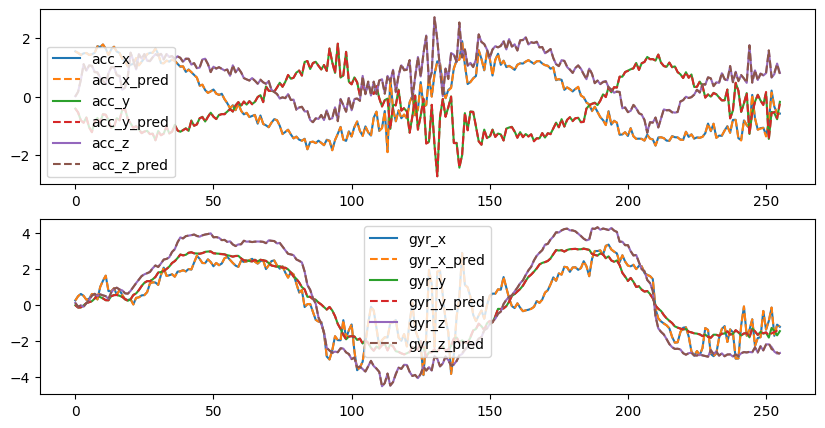

In [ ]:
# loss < 0.0000 perfect
# loss = 0.0000167 perfect
# loss = 0.0000395 perfect
model.load_state_dict(torch.load('best_model.pth'))
X = next(iter(valloader))
model.eval()
with torch.no_grad():
    Xpred = model(X.to(device)).cpu()

i = 1
j = slice(None, None)
fig,axes = plt.subplots(2,1,figsize=(10, 5))
axes[0].plot(X[i, 0,j].numpy(), label='acc_x')
axes[0].plot(Xpred[i, 0,j].numpy(), label='acc_x_pred', linestyle='--')
axes[0].plot(X[i, 1,j].numpy(), label='acc_y')
axes[0].plot(Xpred[i, 1,j].numpy(), label='acc_y_pred', linestyle='--')
axes[0].plot(X[i, 2,j].numpy(), label='acc_z')
axes[0].plot(Xpred[i, 2,j].numpy(), label='acc_z_pred', linestyle='--')
axes[1].plot(X[i, 3,j].numpy(), label='gyr_x')
axes[1].plot(Xpred[i, 3,j].numpy(), label='gyr_x_pred', linestyle='--')
axes[1].plot(X[i, 4,j].numpy(), label='gyr_y')
axes[1].plot(Xpred[i, 4,j].numpy(), label='gyr_y_pred', linestyle='--')
axes[1].plot(X[i, 5,j].numpy(), label='gyr_z')
axes[1].plot(Xpred[i, 5,j].numpy(), label='gyr_z_pred', linestyle='--')
axes[0].legend()
axes[1].legend()